# requirements:
```
pandas
mecab-python3
scikit-learn
matplotlib
nlplt
```

In [9]:
import pandas as pd
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nlplot

In [13]:
def mecab_sep(text,stopwords=['ため','とも']):
	# tagger = MeCab.Tagger()
    tagger = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
    node = tagger.parseToNode(text)
    words_list = []
    while node:
        if node.feature.split(",")[0] in ["名詞"] and node.surface not in stopwords:
            words_list.append(node.surface)
        node = node.next
        
    return words_list

### Bag-of-words / tf-idf
def calc_vecs(docs):
	vectorizer = TfidfVectorizer(analyzer=mecab_sep)
	vecs = vectorizer.fit_transform(docs)
	return vecs.toarray()

In [14]:
df = pd.read_csv("datasets/bachelor_themes.csv",encoding='UTF-8')
tatget_labs = [
    '朝廣研','安部研','石田研','合志研','下川研',
    '成研','田中研','仲研','米元研','アプドゥハン研',
    '稲永研','于研','石田俊研','澤田研','安武研','前田研']

target_docs_df = df[df["研究室"].isin(tatget_labs )] 
target_docs_df.head()

年度 学科／研究科  研究室  学籍番号   賞  氏名   要旨                                    題目
3   H17  情報科学科   成研   NaN NaN NaN  NaN                 対面教育を支援するためのウェブ助言システム
6   H17  情報科学科   仲研   NaN NaN NaN  NaN                      生化学反応シミュレータの比較評価
7   H17  情報科学科  澤田研   NaN NaN NaN  NaN  FPGAを搭載したロボット教材のためのIPとしてKUE-CHIP2の検討
10  H17  情報科学科  稲永研   NaN NaN NaN  NaN              空港における目的地への交通手段検索システムの開発
11  H17  情報科学科  合志研   NaN NaN NaN  NaN              人の反応・判断能力測定用ドライビングシミュレータ

In [34]:
target_docs = target_docs_df["題目"].tolist()
all_docs_vecs = calc_vecs(target_docs_df["題目"])
n_clust = 10
# 参考：KMeans　k-means法によるクラスタリング
#  https://sabopy.com/py/scikit-learn-11/
vec = KMeans(n_clusters=n_clust, init="k-means++",random_state=2024, n_init="auto") # random_state keeps clustering deterministic 
vec.fit(all_docs_vecs)
m = len(vec.labels_)
vec.labels_[:10]

array([0, 5, 4, 3, 1, 3, 3, 3, 3, 5], dtype=int32)

In [35]:
# target_docs_df["クラス"] = vec.labels_
target_docs_df.loc[:,['クラスタ']] = vec.labels_
pd.crosstab(target_docs_df["研究室"],target_docs_df["クラスタ"])
cross_survive= pd.crosstab(target_docs_df['クラスタ'], target_docs_df['研究室'],normalize='index')
target_docs_df.head()

年度 学科／研究科  研究室  学籍番号   賞  氏名   要旨                                    題目  \
3   H17  情報科学科   成研   NaN NaN NaN  NaN                 対面教育を支援するためのウェブ助言システム   
6   H17  情報科学科   仲研   NaN NaN NaN  NaN                      生化学反応シミュレータの比較評価   
7   H17  情報科学科  澤田研   NaN NaN NaN  NaN  FPGAを搭載したロボット教材のためのIPとしてKUE-CHIP2の検討   
10  H17  情報科学科  稲永研   NaN NaN NaN  NaN              空港における目的地への交通手段検索システムの開発   
11  H17  情報科学科  合志研   NaN NaN NaN  NaN              人の反応・判断能力測定用ドライビングシミュレータ   

    クラスタ  
3      0  
6      5  
7      4  
10     3  
11     1

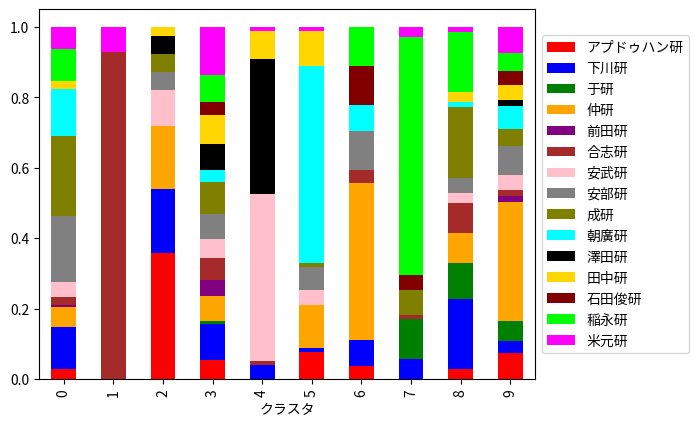

In [36]:
#文字化け
# plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams["font.family"] = "Noto Sans CJK JP"
# plt.figure(figsize=[15,20])
#カラー
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", 
        ["red", "blue", "green","orange", "purple", "brown", "pink", "gray", "olive", "cyan", 
         "black", "gold", "maroon", "lime", "fuchsia", "tan"])

cross_survive.plot.bar(stacked=True)
plt.legend( loc='center left', bbox_to_anchor=(1., .5))
# 注意：クラスタリング結果は初期値によって変わる

In [37]:
k=5
df1 = target_docs_df[target_docs_df['クラスタ']==k]
df1.head()

年度 学科／研究科  研究室  学籍番号   賞  氏名   要旨  \
6   H17  情報科学科   仲研   NaN NaN NaN  NaN   
19  H17  情報科学科  安部研   NaN NaN NaN  NaN   
73  H17  情報科学科  安部研   NaN NaN NaN  NaN   
76  H17  情報科学科  安部研   NaN NaN NaN  NaN   
96  H17  情報科学科   仲研   NaN NaN NaN  NaN   

                                                   題目  クラスタ  
6                                    生化学反応シミュレータの比較評価     5  
19  組み合わせ最適化問題に対するメタヒューリスティクスの実験的解析(1)局所探索系手法の適応-基...     5  
73  組合せ最適化問題に対するメタヒューリスティクスの実験的解析　(3)タブーサーチの適用－基本的...     5  
76  組合せ最適化問題に対するメタヒューリスティクスの実験的解析　(2)シミュレーテッド・アニーリ...     5  
96                 数値計算・数式処理ソフトの調査と生化学反応シミュレーションによる評価     5

In [38]:
# 研究室リスト（件数の多い順）
vc = df1['研究室'].value_counts()
n = sum(vc.values)
print(n)
title=",".join([f"{k}({c})" for k,c in vc.items() if c>0.05*n])
print(title)

91
朝廣研(51),仲研(11),田中研(9),アプドゥハン研(7),安部研(6)


In [39]:
texts =[]
for text in df1['題目'].values:
    texts += [" ".join(mecab_sep(text))]
texts[:5]

['生化学 反応 シミュレータ 比較 評価',
 '組み合わせ最適化 問題 メタヒューリスティクス 実験的 解析 1 局所 探索 系 手法 適応 基本的 性能 評価',
 '組合せ最適化 問題 メタヒューリスティクス 実験的 解析 3 タブーサーチ 適用 基本的 性能 評価',
 '組合せ最適化 問題 メタヒューリスティクス 実験的 解析 2 シミュレーテッド・アニーリング 適用 基本的 性能 評価',
 '数値計算 数式 処理 ソフト 調査 生化学 反応 シミュレーション 評価']

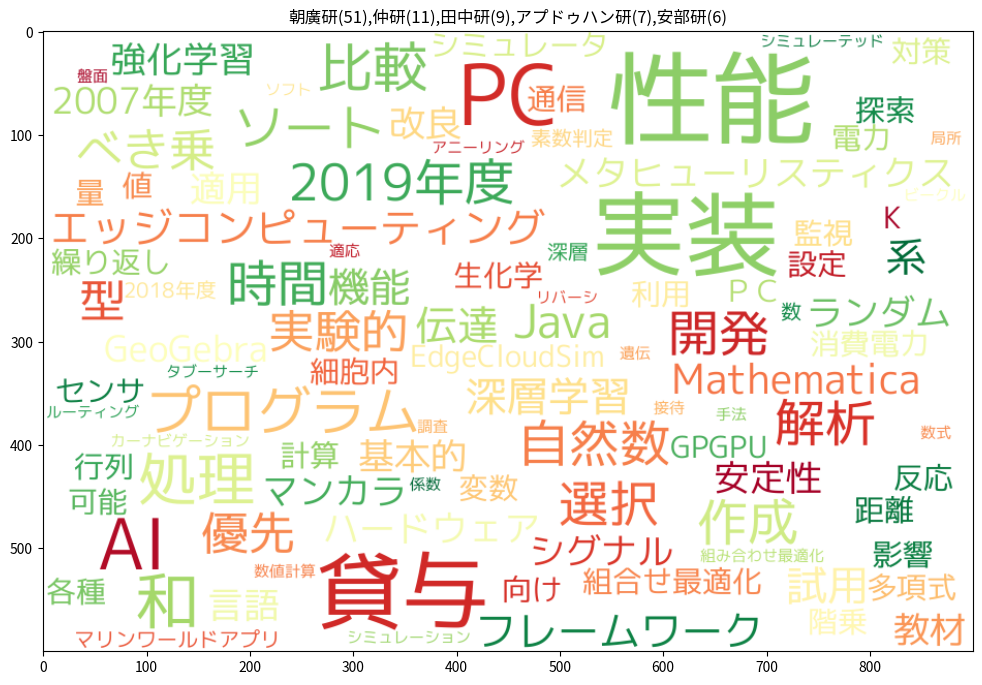

In [40]:
df2 = pd.DataFrame({'text': texts})
npt = nlplot.NLPlot(df2, target_col='text')
# Stopword calculations can be performed.
stopwords = npt.get_stopword(top_n=4, min_freq=0)

fig = plt.figure(figsize=(12, 20))
fig.tight_layout()
fig_wc = npt.wordcloud(
    width = 900,
    height = 600,
    max_words = 100,
    max_font_size = 100,
    colormap = 'RdYlGn', # 'tab20_r',
    stopwords =stopwords,
    mask_file = None,
    save=False
)

# plt.axis('off') 
plt.title(title)
plt.imshow(fig_wc, interpolation="bilinear")      
plt.show()

Cluster No.0: 成研(40),安部研(33),朝廣研(23),下川研(21),稲永研(16),米元研(11),仲研(10)


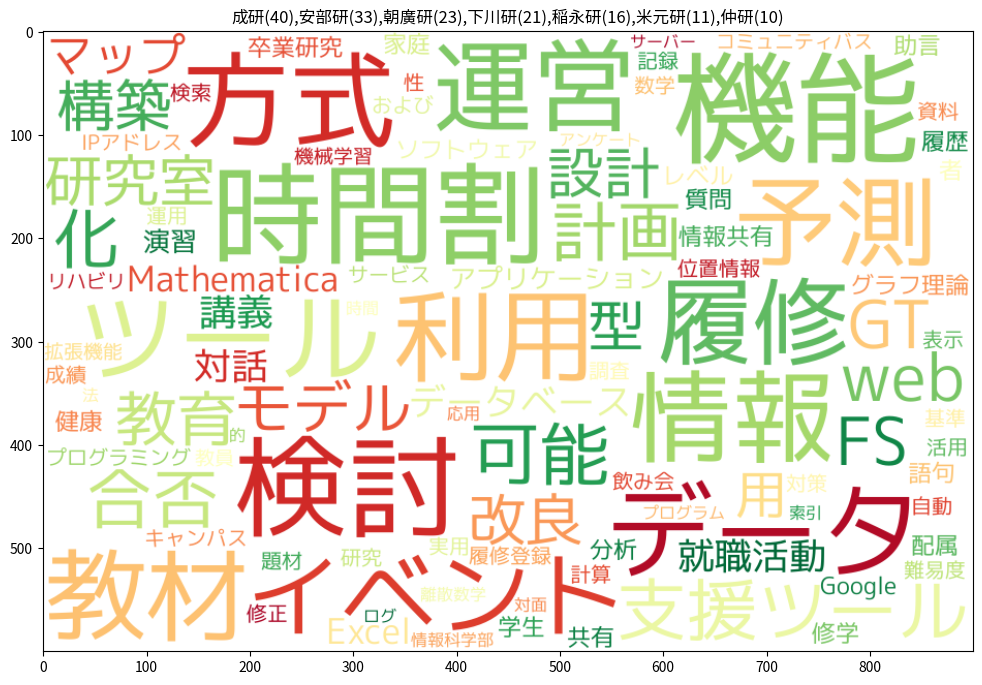

Cluster No.1: 合志研(52),米元研(4)


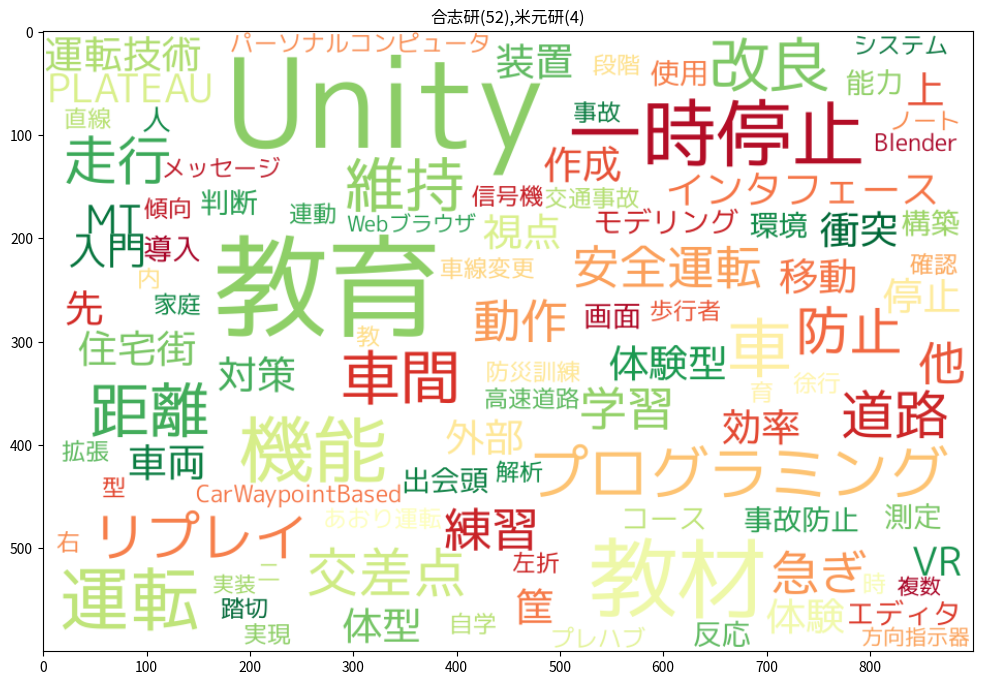

Cluster No.2: アプドゥハン研(14),仲研(7),下川研(7),安武研(4),安部研(2),成研(2),澤田研(2)


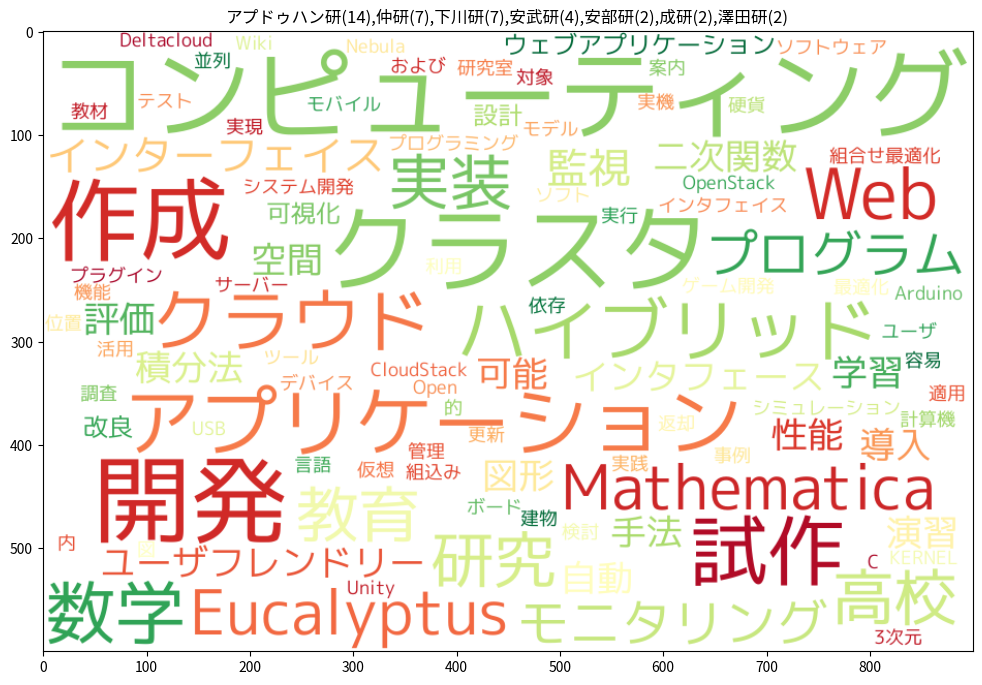

Cluster No.3: 米元研(114),下川研(86),成研(76),田中研(68),稲永研(63),澤田研(62),仲研(60),安部研(58),合志研(54),アプドゥハン研(45),安武研(44)


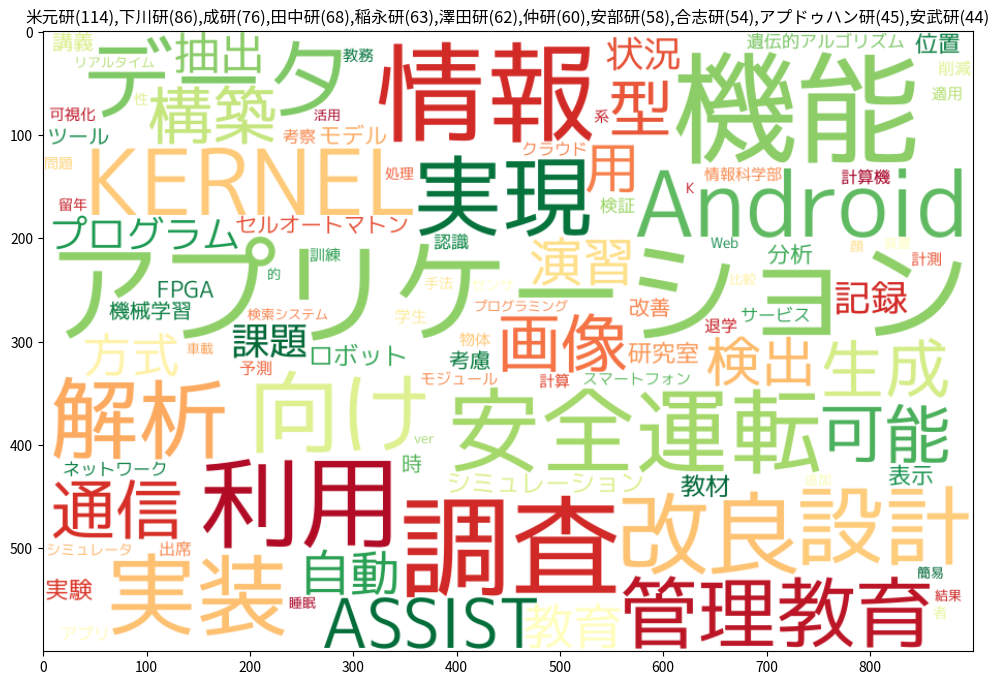

Cluster No.4: 安武研(37),澤田研(30),田中研(6)


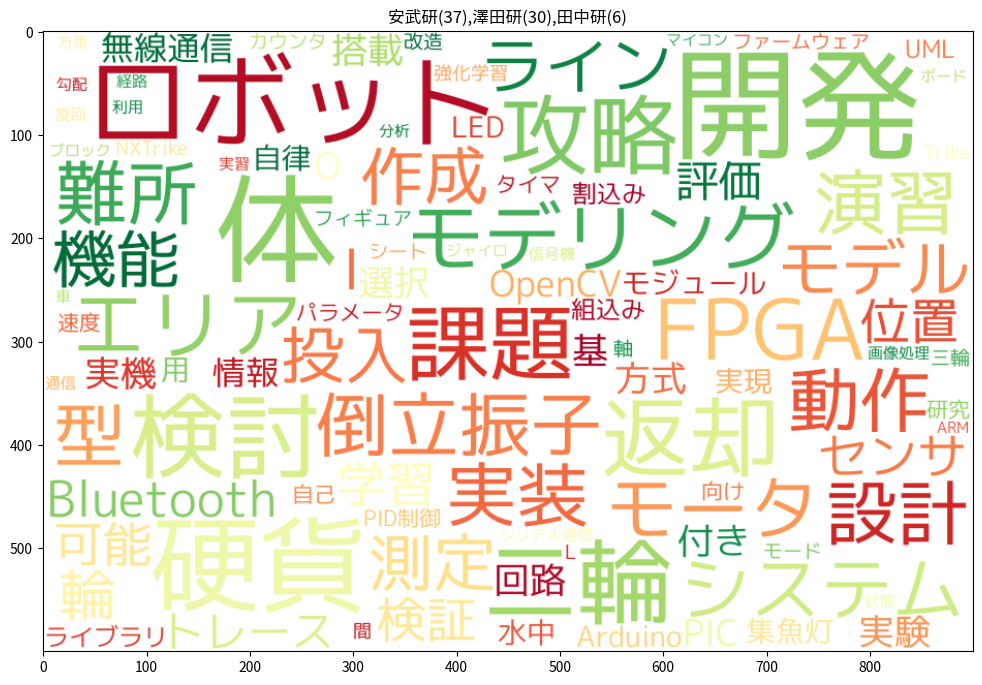

Cluster No.5: 朝廣研(51),仲研(11),田中研(9),アプドゥハン研(7),安部研(6)


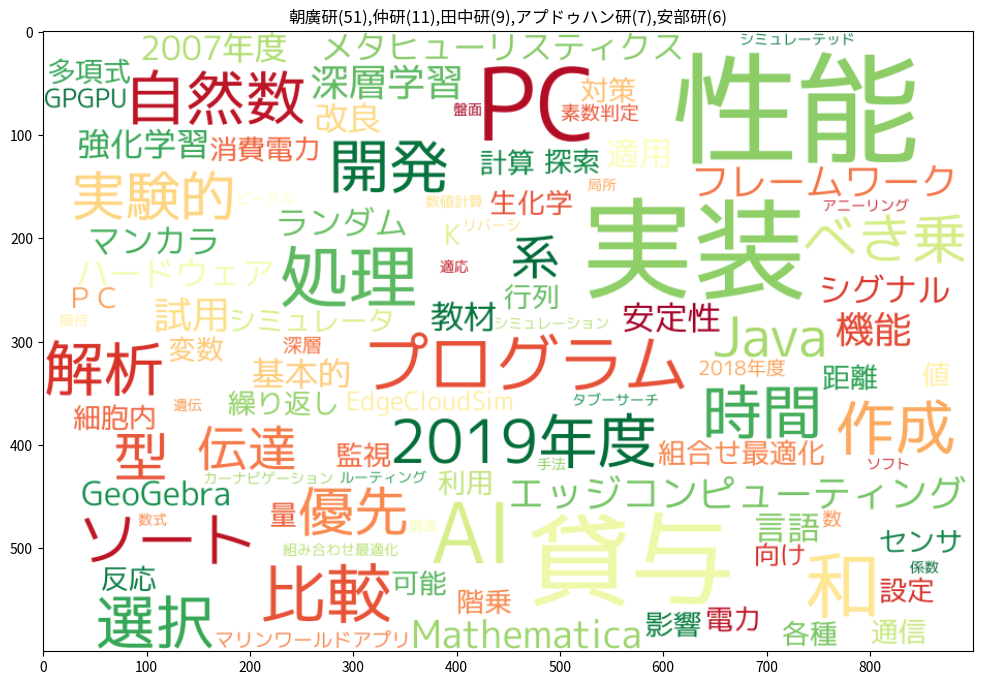

Cluster No.6: 仲研(12),稲永研(3),石田俊研(3),安部研(3),朝廣研(2),下川研(2)


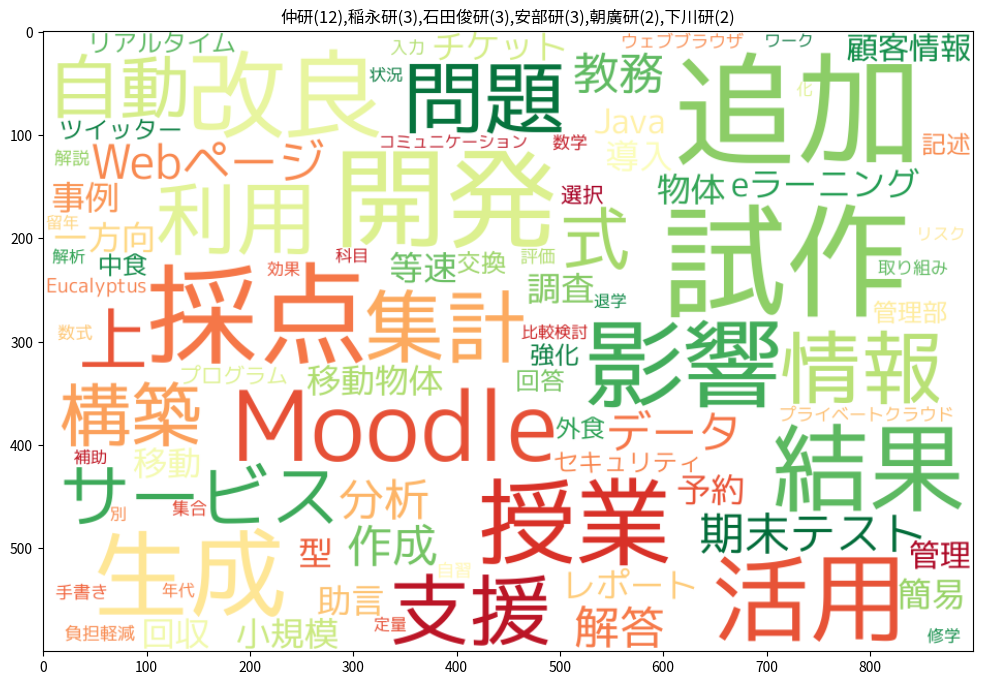

Cluster No.7: 稲永研(48),于研(8),成研(5),下川研(4)


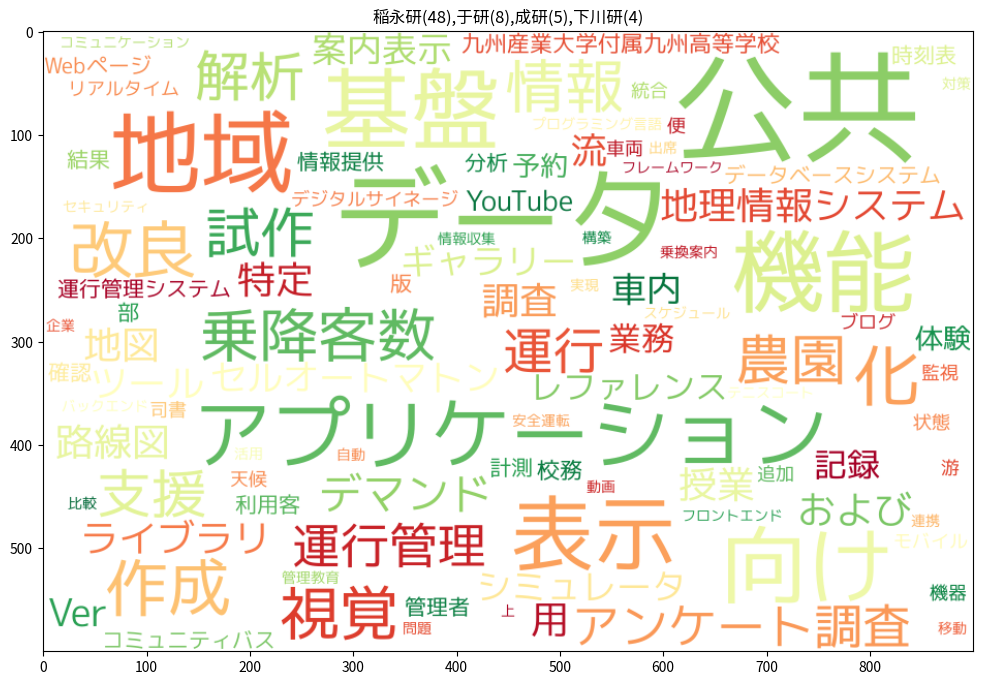

Cluster No.8: 下川研(14),成研(14),稲永研(12),于研(7),合志研(6),仲研(6)


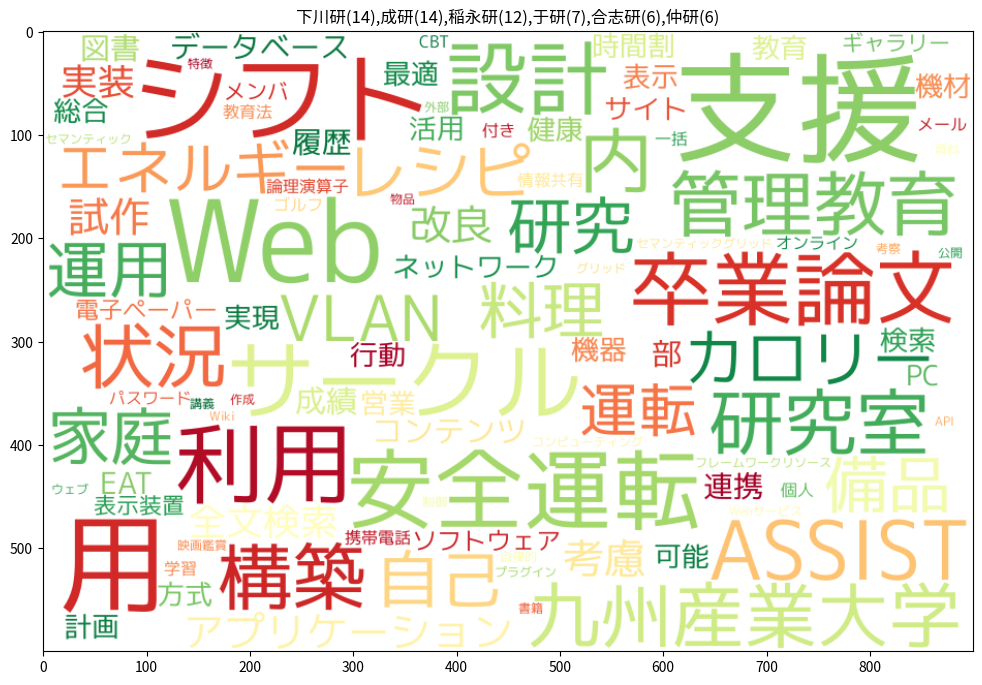

Cluster No.9: 仲研(41),安部研(10),アプドゥハン研(9),米元研(9),朝廣研(8),于研(7)


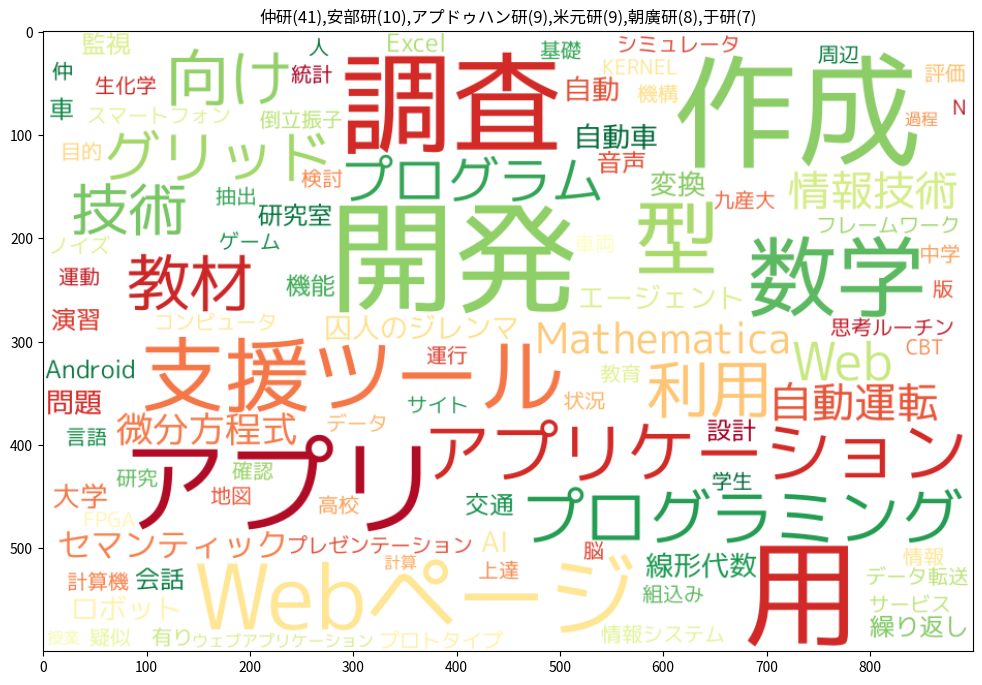

In [41]:
for k in range(n_clust):
    df1 = target_docs_df[target_docs_df['クラスタ']==k]
    vc = df1['研究室'].value_counts()
    n = sum(vc.values)
    title=",".join([f"{k}({c})" for k,c in vc.items() if c>0.05*n])
    print(f"Cluster No.{k}: {title}")
    
    texts =[]
    for text in df1['題目'].values:
        texts += [" ".join(mecab_sep(text))]
    df2 = pd.DataFrame({'text': texts})
    
    npt = nlplot.NLPlot(df2, target_col='text')
    # Stopword calculations can be performed.
    stopwords = npt.get_stopword(top_n=4, min_freq=0)
    
    fig = plt.figure(figsize=(12, 20))
    fig.tight_layout()
    fig_wc = npt.wordcloud(
        width = 900,
        height = 600,
        max_words = 100,
        max_font_size = 120,
        colormap = 'RdYlGn', # 'tab20_r',
        stopwords =stopwords,
        mask_file = None,
        save=False
    )
    
    # plt.axis('off') 
    plt.title(title)
    plt.imshow(fig_wc, interpolation="bilinear")      
    plt.show()